Examples of how one extra feature allows to effectively use KMeans on unusual data:  
https://juanitorduz.github.io/spectral_clustering/ - See the Final Remarks section

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import itertools
import itertools
import math
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
import tsfresh.feature_extraction.feature_calculators as fc
# https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.manifold import TSNE
plt.style.use('fivethirtyeight')
%matplotlib inline
#%matplotlib notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## 1. AUXILIARY FUNCTIONS

### a) 2D PCA and tSNE side by side

In [2]:
# 2D PCA and tSNE side by side
def plot_2D_pca_tsne(data_all, data_tsne_local, labels, cmethod='K-Means'):
        
    # do PCA
    data_all = deepcopy(data_all)
    pca_2 = PCA(2)
    projected = pca_2.fit_transform(data_all)
    df_proj = pd.DataFrame(projected, columns=['pc_1', 'pc_2'])
    df_proj['labels'] = labels
    
    data_tsne_local = deepcopy(data_tsne_local)
    data_tsne_local['labels'] = labels

    # plot PCA & tSNE
    n_clust = len(set(labels))
    plt.figure(figsize=(8, 10))
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title('PCA 2D, {} clusters'.format(cmethod.replace('_', ' '), n_clust))
    sns.scatterplot(
        x="pc_1", y="pc_2",
        hue='labels',
        palette=sns.color_palette("hls", n_clust),
        data=df_proj,
        legend="full",
        alpha=0.3,
        ax=ax1
    )
    ax2 = plt.subplot(2, 1, 2)
    ax2.set_title('tSNE 2D, {} clusters'.format(cmethod.replace('_', ' '), n_clust))
    sns.scatterplot(
        x="tsne2_1", y="tsne2_2",
        hue='labels',
        palette=sns.color_palette("hls", n_clust),
        data=data_tsne_local,
        legend="full",
        alpha=0.3,
        ax=ax2
    )
    plt.tight_layout()

In [3]:
# 2D PCA plot
def plot_2D_pca(data_all, labels, cmethod='K-Means'):
        
    # do PCA
    data_all = deepcopy(data_all)
    pca_2 = PCA(2)
    projected = pca_2.fit_transform(data_all)
    df_proj = pd.DataFrame(projected, columns=['pc_1', 'pc_2'])
    df_proj['labels'] = labels
        
    # plot PCA & tSNE
    n_clust = len(set(labels))
    plt.figure(figsize=(11, 7))
    #ax1 = plt.subplot(1, 1, 1)
    #ax1.set_title('PCA 2D, {} clusters'.format(cmethod.replace('_', ' '), n_clust))
    sns.scatterplot(
        x="pc_1", y="pc_2",
        hue='labels',
        palette=sns.color_palette("hls", n_clust),
        data=df_proj,
        legend="full",
        alpha=0.3,
        
    )
    plt.title('PCA 2D, {} clusters'.format(cmethod.replace('_', ' ')))
    plt.tight_layout()

### b) 3D PCA Visualization

In [4]:
#### 3D plot
def plot_3d_pca(_data, _labels):
        
    # dimensionality reduction
    n_clust = len(set(_labels.tolist()))
    pca_3 = PCA(3)
    projected = pd.DataFrame(pca_3.fit_transform(_data), columns=['pc_1', 'pc_2', 'pc_3'])
    print('Explained variance with 3 components:', sum(pca_3.explained_variance_ratio_))
    
    # plotting
    ax = plt.figure(figsize=(10,5)).gca(projection='3d')
    ax.scatter(
        xs=projected['pc_1'], 
        ys=projected['pc_2'], 
        zs=projected['pc_3'], 
        c=_labels, 
        cmap='tab10'
    )
    ax.set_xlabel('pc_1')
    ax.set_ylabel('pc_2')
    ax.set_zlabel('pc_3')
    plt.title('PCA 3D Visualization, K-Means w/{} clusters'.format(n_clust))
    plt.tight_layout(pad=0)
    plt.show()

### c) 3D tSNE

In [5]:
%matplotlib inline
def plot_3d_tsne(_data, _labels):
    
    # plotting (refresh kernel for %matplotlib notebook)
    ax = plt.figure(figsize=(10,5)).gca(projection='3d')
    ax.scatter(
        xs=_data['tsne3_1'], 
        ys=_data['tsne3_2'], 
        zs=_data['tsne3_3'], 
        c=_labels, 
        cmap='tab10'
    )
    ax.set_xlabel('tsne3_1')
    ax.set_ylabel('tsne3_2')
    ax.set_zlabel('tsne3_3')
    plt.tight_layout(pad=0)
    plt.show()

### d) Visualize well(s)

In [176]:
def plot_well(df_local, cluster_col, well_name=None):
        
    df_local = deepcopy(df_local[['wellname', 'tvdss_ft', 'nmr_ff_vv', 'nmr_tpor_vv', cluster_col]])
    if well_name:
        df_local = df_local[df_local['wellname'] == well_name]
        
    #fig, (ax1, ax2) = plt.subplots(2, figsize=(16,2))
    #fig.suptitle('Vertically stacked subplots')
    #ax1.plot(df_local['tvdss_ft'], df_local['nmr_tpor_vv'], linewidth=1)
    #ax2.plot(df_local['tvdss_ft'], df_local['nmr_ff_vv'], linewidth=1)
    #plt.show()    
        
    x = df_local['tvdss_ft']
    y = [1 for item in x]
    clusters = df_local[cluster_col]
    
    df_draw = pd.DataFrame(dict(depth=x, one=y, color=clusters))
    fig, ax = plt.subplots(figsize=(16,2))
    color_map = {0:'tab:green', 1:'tab:orange', 2:'tab:cyan', 3:'tab:pink', 4:'tab:blue', 5:'tab:olive', 6:'tab:gray', 7:'tab:red'}
    ax.scatter(df_draw['depth'], df_draw['one'], c=df_draw['color'].apply(lambda x: color_map[x]), s=3500, marker="|")
        
    clusters_unique = sorted(df_local[cluster_col].unique().tolist())
        
    patchList = []
    for cluster in clusters_unique:
            data_key = mpatches.Patch(color=color_map[cluster], label=cluster)
            patchList.append(data_key)

    plt.legend(handles=patchList, loc='upper right', fontsize=8)    
        
    title = ''
    if well_name:
        title += 'Well ' + well_name + ': '
    else:
        title += 'All wells: '
    title += cluster_col.replace('_', ' ') + ' clusters'
    ax.set_title(title, fontsize=15)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(25))
    plt.xticks(rotation=-90)
    plt.yticks([])
    plt.show()
    
    #'nmr_ff_vv', 'nmr_tpor_vv'

## 2. START OF MAIN PART

### a) Data ingestion

In [7]:
# READ IN DATA
df_original = pd.read_csv('./data/norphlet_subset_moving_window_additional_features_20200704.csv', encoding='utf8',
                dtype={'wellname': str, 'field': str,  'field_part': str, 'filename' : str,
                       'wellname_old': str, 'dataset_name': str, 'depth_range': str})

df_original = df_original[[c for c in df_original.columns if 'Unnamed' not in c]]

In [8]:
# MAIN FEATURES
corr_features = ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'nmr_ff_vv', 'nmr_tpor_vv', 'dt']

In [9]:
# THESE FEATURES ARE CORRELATED WITH NMR_TPOR AND NMR_FF
nmrtpor_features = ['dt_absolute_sum_of_changes', 'dt_cid_ce', 'dt_mean_abs_change', 'dt_standard_deviation', 'dt_variance',
                    'dt_variation_coefficient', 'gr_gapi_absolute_sum_of_changes', 'gr_gapi_cid_ce', 'gr_gapi_maximum',
                    'gr_gapi_mean_abs_change', 'gr_gapi_standard_deviation', 'gr_gapi_variance',
                    'gr_gapi_variation_coefficient', 'neutron_cfcf_abs_energy', 'rdeep_ohm_m_abs_energy',
                    'rdeep_ohm_m_absolute_sum_of_changes', 'rdeep_ohm_m_cid_ce', 'rdeep_ohm_m_mean_abs_change',
                    'rdeep_ohm_m_minimum', 'rdeep_ohm_m_standard_deviation', 'rdeep_ohm_m_variance']

nmrff_features   = ['density_g_cm3_abs_energy','dt_abs_energy','dt_absolute_sum_of_changes','dt_cid_ce','dt_mean_abs_change',
                    'dt_minimum', 'gr_gapi_absolute_sum_of_changes', 'gr_gapi_cid_ce', 'gr_gapi_maximum',
                    'gr_gapi_mean_abs_change','gr_gapi_standard_deviation','gr_gapi_variance','gr_gapi_variation_coefficient',
                    'neutron_cfcf_abs_energy', 'rdeep_ohm_m_minimum']


# THESE FEATURES ARE CORRELATED WITH OTHER 5 MAIN FEATURES (NOT NMT_TPOR OR NMR_FF)
other_features   = ['density_g_cm3_minimum', 'dt_maximum', 'dt_mean', 'dt_sum_values', 'gr_gapi_minimum',
                    'neutron_cfcf_absolute_sum_of_changes', 'neutron_cfcf_cid_ce',
                    'neutron_cfcf_maximum', 'neutron_cfcf_mean_abs_change']


# NMR_TPOR AND NMR_FF SUBFEATURES CORRELATED WITH OTHER MAIN FEATURES (NOT NMT_TPOR OR NMR_FF)
nmrtpor_sub      = ['nmr_tpor_vv_cid_ce', 'nmr_tpor_vv_mean_abs_change', 'nmr_tpor_vv_absolute_sum_of_changes',
                    'nmr_tpor_vv_longest_strike_below_mean']

nmrff_sub        = ['nmr_ff_vv_cid_ce', 'nmr_ff_vv_mean_abs_change', 'nmr_ff_vv_absolute_sum_of_changes',
                    'nmr_ff_vv_longest_strike_below_mean']

additional_features = sorted(list(set(nmrtpor_features + nmrff_features + other_features + nmrtpor_sub + nmrff_sub)))
print('Length of additional features:', len(additional_features))

Length of additional features: 41


In [10]:
dt_features = [i for i in additional_features if 'dt_' in i]
gr_features = [i for i in additional_features if 'gr_gapi_' in i]
rd_deatures = [i for i in additional_features if 'rdeep_' in i]

In [11]:
print(df_original.shape)
df_original.head(2)

(14273, 248)


,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

In [12]:
# CHECKING FOR MISSING VALUES
df_original[corr_features + additional_features].isna().sum()

density_g_cm3                            0
rdeep_ohm_m                              0
gr_gapi                                  0
neutron_cfcf                             0
nmr_ff_vv                                0
nmr_tpor_vv                              0
dt                                       0
density_g_cm3_abs_energy                 0
density_g_cm3_minimum                    0
dt_abs_energy                            0
dt_absolute_sum_of_changes               0
dt_cid_ce                                0
dt_maximum                               0
dt_mean                                  0
dt_mean_abs_change                       0
dt_minimum                               0
dt_standard_deviation                    0
dt_sum_values                            0
dt_variance                              0
dt_variation_coefficient                 0
gr_gapi_absolute_sum_of_changes          0
gr_gapi_cid_ce                           0
gr_gapi_maximum                          0
gr_gapi_mea

In [13]:
# DATA POINTS PER WELL
print('Data points per well:')
for well in df_original['wellname'].unique():
    print('\t{}: {} datapoints'.format(well, df_original[df_original['wellname'] == well].shape[0]))

Data points per well:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 3679 datapoints
	MC525-2: 1173 datapoints
	MC612-1BP1: 2175 datapoints


In [14]:
# OIL = 2, WATER = 1
df_original['fluid'].value_counts()

2.0    12516
1.0     1757
Name: fluid, dtype: int64

In [15]:
# DATA POINTS PER WELL IN OIL
print('Data points per well in oil (only three wells have water):')
for well in df_original['wellname'].unique():
    print('\t{}: {} datapoints'.format(well, df_original[(df_original['wellname'] == well) & (df_original['fluid'] == 2)].shape[0]))

Data points per well in oil (only three wells have water):
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 2709 datapoints
	MC525-2: 874 datapoints
	MC612-1BP1: 1687 datapoints


In [16]:
print('Min depth:', df_original['tvdss_ft'].min())
print('Max depth:', df_original['tvdss_ft'].max())
print('Difference:', math.ceil(df_original['tvdss_ft'].max() - df_original['tvdss_ft'].min()))

Min depth: 24320.04
Max depth: 28559.0401761094
Difference: 4240


In [17]:
# ZERO DUPLICATES
df_original[df_original[corr_features + additional_features].duplicated()]

,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

### b) Feature selection

In [42]:
# ALL NUMERIC FIELDS
to_exclude = ['md_ft', 'dtc_us_ft', 'dts_us_ft', 'fluid', 'nmr_bw_vv', 'nmr_cbw_vv', 'wellname', 'field', 'field_part',
              'filename', 'wellname_old', 'dataset_name', 'tvd_ft', 'tvdbml_ft', 'tvdss_ft', 'rmedium_ohm_m', 'rshallow_ohm_m',
              'density_g_cm3_sample_entropy', 'rdeep_ohm_m_sample_entropy', 'gr_gapi_sample_entropy',
              'neutron_cfcf_sample_entropy', 'nmr_ff_vv_sample_entropy', 'nmr_tpor_vv_sample_entropy', 'dt_sample_entropy']
bool_cols = [col for col in df_original.columns if df_original[col].dtype == bool]
to_exclude = to_exclude + bool_cols

to_include = [col for col in df_original.columns if col not in to_exclude]

In [220]:
winner_prefixes = ['_cid_ce', '_mean_abs_change', '_standard_deviation']    #'_absolute_sum_of_changes', '_variation_coefficient', '_abs_energy', '_variance'

winner_features2 = [i + '_mean' for i in corr_features]

winner_features = []
for item in winner_prefixes:
    temp = [i for i in to_include if item in i]
    winner_features.extend(temp)
    
winner_features = sorted(list(set(winner_features + winner_features2)))
#winner_features = [i for i in winner_features if 'rdeep_' in i or 'neutron_' in i or 'density_' in i]
len(winner_features)

28

In [221]:
# nmrtpor_features + nmrff_features + other_features + nmrtpor_sub + nmrff_sub
# df_features + gr_features + rd_deatures
# winner = nmrff_features + dt_features + gr_features
select_features = sorted(list(set(nmrff_features + dt_features + gr_features + winner_features)))
all_features = corr_features + select_features
#all_features = [i for i in all_features if i not in ['density_g_cm3_abs_energy', 'density_g_cm3']]
print('Length of all features:', len(all_features))

Length of all features: 50


In [104]:
# used when each well was scaled separately
def data_prep_old(_data_original, _features, well_name=False):
        
    # copy data
    _df = deepcopy(_data_original)
    
    # data subset by well_name
    if well_name:
        if well_name in _df['wellname'].unique():
            _df = _df[_df['wellname'] == well_name]
        else:
            print('Well not found - all data will be used')
        
    # scale data
    standard_scaler = StandardScaler()
    _df[_features] = standard_scaler.fit_transform(_df[_features])
    
    return _df

def data_prep(_df, well_name):
    
    _df = deepcopy(_df)
    
    # data subset by well_name    
    if well_name in _df['wellname'].unique():
        _df = _df[_df['wellname'] == well_name]
    else:
        print('Well not found - all data will be used')
        
    _df = _df.drop(['wellname', 'tvdss_ft'], axis=1)
    
    return _df

def do_pca(_data, expl_var = 0.95):    
        
        _data = deepcopy(_data)
        idx = _data.index
                
        pca = PCA(expl_var).fit(_data)
        print('Reducing from {} columns to {} components for explained variance {}'.format(_data.shape[1], pca.n_components_, expl_var))
        _data = pca.transform(_data)
        _data = pd.DataFrame(_data)
        _data = _data.set_index(idx)
                
        print('New shape of data:', _data.shape)
        
        return _data

### c) Search for optimal number of clusters
* MC348-3ST1: 551 datapoints
* MC391-1: 2713 datapoints
* MC392-1: 950 datapoints
* MC392-1ST1: 3032 datapoints
* MC393-1: 3679 datapoints
* MC525-2: 1173 datapoints
* MC612-1BP1: 2175 datapoints

In [159]:
# copy data
df = deepcopy(df_original)

# scale data
standard_scaler = StandardScaler()
df[all_features] = standard_scaler.fit_transform(df[all_features])

In [160]:
# DIMENSIONALITY REDUCTION
pca_flag = True
if pca_flag:
    data_all = do_pca(df[all_features])
else:
    data_all = df[all_features]
data_all.head(2)

Reducing from 50 columns to 14 components for explained variance 0.95
New shape of data: (14273, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,19.174828,1.207965,-5.706559,-8.934964,0.024439,0.53557,-3.952788,7.307501,0.791923,-4.004628,1.624895,0.172735,-0.974631,2.577581
1,18.846135,2.147673,-5.590024,-9.128812,-0.153370,0.87631,-3.509398,7.230590,0.426638,-4.044933,2.009936,0.517432,-1.524745,2.748930


In [161]:
data_all['wellname'] = df['wellname']
data_all['tvdss_ft'] = df['tvdss_ft']
data_all['nmr_ff_vv'] = df_original['nmr_ff_vv']
data_all['nmr_tpor_vv'] = df_original['nmr_tpor_vv']

In [214]:
wells = df_original['wellname'].unique().tolist()
THIS_WELL = wells[6]
print('Selected {} from {}'.format(THIS_WELL, wells))

Selected MC612-1BP1 from ['MC348-3ST1', 'MC391-1', 'MC392-1', 'MC392-1ST1', 'MC393-1', 'MC525-2', 'MC612-1BP1']


In [215]:
# SELECT WELL AND DATA SUBSET
data = data_prep(data_all, THIS_WELL)
print('Shape of data for well {}: {}'.format(THIS_WELL, data.shape))
data.head(2)

Shape of data for well MC612-1BP1: (2175, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,nmr_ff_vv,nmr_tpor_vv
12098,29.227843,-2.501703,-17.89650,-4.146899,5.52599,-2.658405,-13.688801,-7.196934,9.200595,-5.225854,4.370077,0.934053,-0.197311,0.308285,0.054237,0.085270
12099,29.136728,-2.305695,-18.33163,-3.763091,5.71809,-2.786201,-13.508011,-7.186136,8.954384,-5.218391,3.926490,0.928702,0.105169,0.274014,0.064214,0.099813


Shape of data: (2175, 16)
Converged after these iterations: [2, 5, 30, 16, 13, 45, 38, 20, 17, 31, 24, 26, 37, 39, 30]


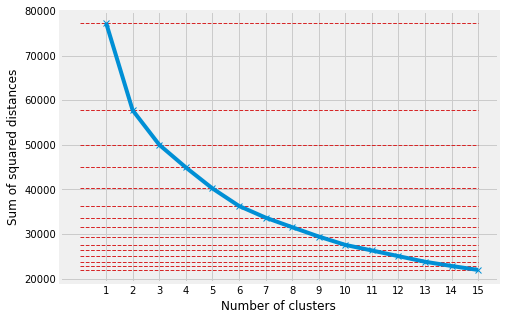

In [216]:
# FIND OPTIMAL NUMBER OF CLUSTERS (ELBOW METHOD)
%matplotlib inline

print('Shape of data:', data.shape)   
Sum_of_squared_distances = []
n_iterations = []
K = range(1, 16)
for k in K:    
    km = KMeans(n_clusters=k, n_init=25, max_iter=1000, algorithm='full', tol=0.00001)   # algorithm='full', 'elkan', tol=0.0001
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)
    n_iterations.append(km.n_iter_)

print('Converged after these iterations:', n_iterations)
plt.figure(figsize=(7,5))
plt.plot(K, Sum_of_squared_distances, 'x-')
for point in Sum_of_squared_distances:
    plt.hlines(y=point, xmin=0, xmax=len(K), colors='tab:red', linestyles='--', lw=1)
plt.xticks(K)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

In [217]:
# DELETE - WORKING CODE FOR CONVENIENCE
# change n_clusters as needed
n_clusters = 6
column_name = 'kmeans_' + str(n_clusters)

km = KMeans(n_clusters=n_clusters, n_init=25, max_iter=1000, algorithm='full', tol=0.00001, n_jobs=-1)    # 'elkan'
km.fit(data)

print('max_iter=1000 with tolerance=0.00001')
print('Converged in {} iterations'.format(km.n_iter_))
print('K-Means Inertia: {}'.format(km.inertia_))

max_iter=1000 with tolerance=0.00001
Converged in 41 iterations
K-Means Inertia: 36289.837887600705


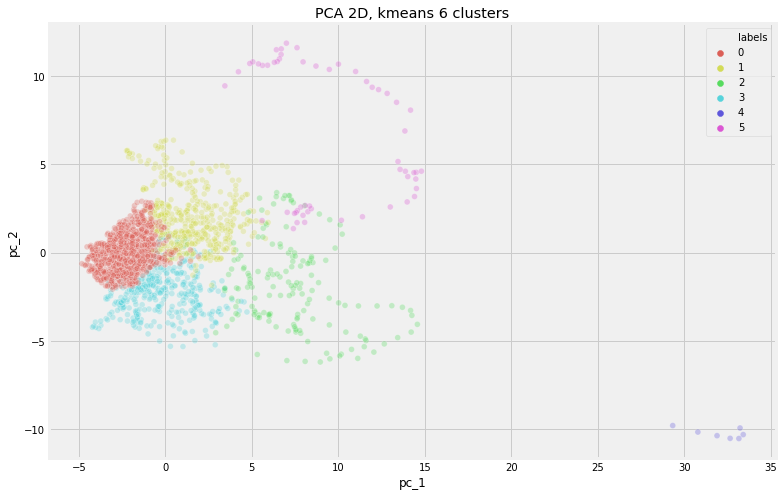

In [218]:
# DELETE - WORKING CODE FOR CONVENIENCE
column_name = 'kmeans_' + str(n_clusters)
plot_2D_pca(data, km.labels_, column_name)

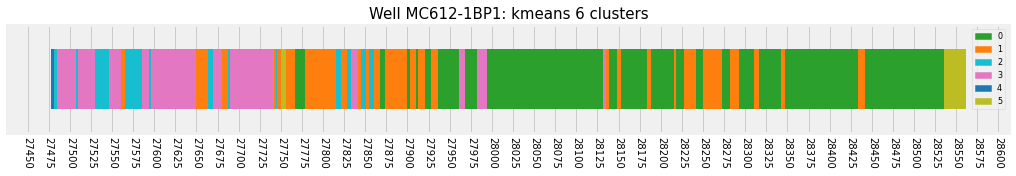

In [219]:
# DELETE - WORKING CODE FOR CONVENIENCE
df_temp = deepcopy(data_all.loc[data.index])
df_temp[column_name] = km.labels_
plot_well(df_temp, column_name, THIS_WELL)

In [114]:
#4, 4, 6, 5, 6, 7, 6-10
unknown_variable

NameError: name 'unknown_variable' is not defined

In [ ]:
# SIMILAR METHOD FOR OPTIMAL K
second_method = False
if second_method:
    K = range(2, 15)
    kmeans = [KMeans(n_clusters=i, max_iter=1000, algorithm='full', n_init=25, tol=0.00001) for i in K]
    score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]

    plt.plot(K, score)
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('Number of clusters')
    plt.show()

In [ ]:
#df_100clusters = pd.DataFrame({'K': K, 'Squ_dist_sum': Sum_of_squared_distances, 'Scores': score})
#df_100clusters.head(20)

### d) Prepare for 2D and 3D t-SNE visualization

In [ ]:
wells = df['wellname'].unique()
wells

In [ ]:
THIS_WELL = wells[1]
THIS_WELL

In [ ]:
# SELECT WELL AND DATA SUBSET
data_tsne = deepcopy(df[df['wellname'] == THIS_WELL][all_features])
print('Shape of data for well {}: {}'.format(THIS_WELL, data_tsne.shape))
data_tsne.head(2)

In [ ]:
# DIMENSIONALITY REDUCTION
pca_flag = True
if pca_flag:
    explained_var = 0.95
    pca = PCA(explained_var).fit(data_tsne)
    print('# componenets for explained variance {}: {}'.format(explained_var, pca.n_components_))
    data_tsne = pca.transform(data_tsne)
    #filtered = pca.inverse_transform(components)
    data_tsne = pd.DataFrame(data_tsne)
print('Shape of data_tsne:', data_tsne.shape)
data_tsne.head(2)

In [ ]:
# tSNE takes time, so it should be done once outside of visualization functions
# 2-component tSNE
time_start = time.time()
tsne2 = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2500, n_jobs=-1, learning_rate=100.0, early_exaggeration=12.0, 
             n_iter_without_progress=300, metric='euclidean', init='pca')    # init='pca' or 'random'
tsne2_results = tsne2.fit_transform(data_tsne)

data_tsne['tsne2_1'] = tsne2_results[:,0]
data_tsne['tsne2_2'] = tsne2_results[:,1]
print('2-component t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne2_results = None

In [ ]:
# 3-component tSNE
time_start = time.time()
tsne3 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, n_jobs=-1)
tsne3_results = tsne3.fit_transform(data_tsne)

data_tsne['tsne3_1'] = tsne3_results[:,0]
data_tsne['tsne3_2'] = tsne3_results[:,1]
data_tsne['tsne3_3'] = tsne3_results[:,2]
print('3-component t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne3_results = None

### e) Clustering and visualization

In [64]:
wells = df_original['wellname'].unique().tolist()
THIS_WELL = wells[0]
print('Selected {} from {}'.format(THIS_WELL, wells))

Selected MC348-3ST1 from ['MC348-3ST1', 'MC391-1', 'MC392-1', 'MC392-1ST1', 'MC393-1', 'MC525-2', 'MC612-1BP1']


In [68]:
# SELECT WELL AND DATA SUBSET
data_all = data_prep(df_original, THIS_WELL)
print('Shape of data for well {}: {}'.format(THIS_WELL, data_all.shape))
print('Shape of relevant data for well {}: {}'.format(THIS_WELL, data_all[all_features].shape))
data_all[all_features].head(2)

Shape of data for well MC348-3ST1: (551, 246)
Shape of relevant data for well MC348-3ST1: (551, 35)


,density_g_cm3,rdeep_ohm_m,gr_gapi,neutron_cfcf,nmr_ff_vv,nmr_tpor_vv,dt,density_g_cm3_cid_ce,density_g_cm3_mean,density_g_cm3_mean_abs_change,density_g_cm3_standard_deviation,dt_cid_ce,dt_mean,dt_mean_abs_change,dt_standard_deviation,gr_gapi_cid_ce,gr_gapi_mean,gr_gapi_mean_abs_change,gr_gapi_standard_deviation,neutron_cfcf_cid_ce,neutron_cfcf_mean,neutron_cfcf_mean_abs_change,neutron_cfcf_standard_deviation,nmr_ff_vv_cid_ce,nmr_ff_vv_mean,nmr_ff_vv_mean_abs_change,nmr_ff_vv_standard_deviation,nmr_tpor_vv_cid_ce,nmr_tpor_vv_mean,nmr_tpor_vv_mean_abs_change,nmr_tpor_vv_standard_deviation,rdeep_ohm_m_cid_ce,rdeep_ohm_m_mean,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_standard_deviation
0,3.1089,0.293561,26.304100,0.251625,0.00151,0.01434,0.663901,0.242850,2.897700,0.076114,0.202335,0.024192,0.651256,0.006830,0.014186,4.503930,19.837055,1.46225,3.419737,0.041165,0.192897,0.012268,0.028950,0.024391,0.017836,0.007186,0.018497,0.043212,0.046666,0.013286,0.029620,0.287667,0.670318,0.091308,0.233213
1,3.1126,0.365731,23.341801,0.222850,0.00217,0.02735,0.663968,0.243056,2.861678,0.067850,0.216267,0.025899,0.650484,0.007132,0.013552,4.546985,19.491515,1.35750,3.369033,0.041165,0.190236,0.010747,0.028313,0.024425,0.021755,0.006450,0.020665,0.043955,0.050889,0.012631,0.030373,0.287807,0.694267,0.081016,0.230073


In [69]:
# DIMENSIONALITY REDUCTION
pca_flag = True
if pca_flag:
    data = do_pca(data_all[all_features])
else:
    data = data_all[all_features]
data.head(2)

Reducing from 35 columns to 2 components for explained variance 0.95
New shape of data: (551, 2)


,0,1
0,-11.697258,4.501773
1,-14.099109,4.682843


In [67]:
# change n_clusters as needed
n_clusters = 4
column_name = 'kmeans_' + str(n_clusters)

km = KMeans(n_clusters=n_clusters, n_init=25, max_iter=1000, algorithm='full', tol=0.00001, n_jobs=-1)    # 'elkan'
km.fit(data)

print('K-Means Inertia: {} (the smaller the better):'.format(km.inertia_))
print('Converged in {} iterations'.format(km.n_iter_))

K-Means Inertia: 273887.0800530501 (the smaller the better):
Converged in 14 iterations


In [70]:
column_name = 'kmeans_' + str(n_clusters)
plot_2D_pca(data, km.labels_, column_name)

ValueError: Length of values does not match length of index

In [ ]:
# change df column name to reflect n_clusters
data_all[column_name] = km.labels_
for well in data_all['wellname'].unique():
    plot_well(data_all, column_name, well)

In [ ]:
#plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], km.labels_, column_name)

## APPENDIX (irrelevant)

### SpectralClustering
Uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm.

Well diagrams look cleaner, but 'MC348-3ST1' has only 2 clusters when clustering on 4 clusters, and only 3 when clustering on 8 clusters - reasonable? May be because the section begin analyzed in that well is only 120 feet long conpared to over 500 feet in other wells

In [ ]:
data = deepcopy(df[all_features])
sc_n_clusters = 4
model = SpectralClustering(n_clusters=sc_n_clusters, n_init=100, affinity='nearest_neighbors',
                           assign_labels='kmeans', n_jobs=-1) 
sc_labels = model.fit_predict(data)

In [ ]:
column_name = 'spectral_' + str(sc_n_clusters)
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], sc_labels, column_name)

In [ ]:
df[column_name] = sc_labels
wells = df['wellname'].unique().tolist()

for well in wells:
    plot_well(df, column_name, well)

## Expectation Maximization - fine tune hyperparameters!
sklearn.mixture.GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)

BayesianGaussianMixture(*, n_components=1, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, degrees_of_freedom_prior=None, covariance_prior=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)

In [ ]:
# try the above visualization too
data = deepcopy(df[all_features])
n_clusters = 4
gm = GaussianMixture(n_clusters, max_iter=500, n_init=10)
gm_labels = gm.fit_predict(data)

In [ ]:
column_name = 'em_' + str(n_clusters)
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], gm_labels, column_name)

In [ ]:
df[column_name] = gm_labels
wells = df['wellname'].unique().tolist()

for well in wells:
    plot_well(df, column_name, well)

In [ ]:
cols_to_plot = ['kmeans_4', 'denoised_4', 'em_4', 'spectral_4']

for col in cols_to_plot:
    plot_well(df, col)

In [ ]:
#df.to_csv('norphlet_subset_scaled_clustered_additional_features_20200704.csv', encoding='utf8', index='False')

## Next Ideas

In [ ]:
# hw EM

In [ ]:
# NMR_FF regressor w/careful feature selection
# with or without TVDSS?
# "remove" noise first?

In [ ]:
pca = PCA(0.50).fit(noisy)
print(pca.n_components_)
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
df_filtered = pd.DataFrame(filtered)
df_filtered.head()

## Silhouette method for estimating best number of clusters

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

print(__doc__)

# Generating the sample data from make_blobs: one distinct cluster and 3 clusters placed close together.
#X, y = make_blobs(n_samples=500,
#                  n_features=2,
#                  centers=4,
#                  cluster_std=1,
#                  center_box=(-10.0, 10.0),
#                  shuffle=True,
#                  random_state=1)  # For reproducibility

pca_local = PCA(2)
X = deepcopy(df[corr_features])
X = pca_local.fit_transform(X)

range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 18, 20, 25, 30]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(21, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for {} clusters".format(n_clusters))
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clustering visualized")
    ax2.set_xlabel("Component 1")
    ax2.set_ylabel("Component 2")

    plt.suptitle("Silhouette analysis for PCA(2)/KMeans, clusters = {}, silhouette score = {}".format(n_clusters, silhouette_avg),
                 fontsize=21, fontweight='bold')

plt.show()
X = None

__Silhouette scores are very close to each other - this dataset is hard to separate. Marginally highest score in descending order is for 6 clusters, then 4 clusters, then 7 clusters, then 3 clusters__

In [ ]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > self.tol:
                    print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
                    optimized = False

            if optimized:
                break

    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [ ]:
import math

def Euclidean_distance(feat_one, feat_two):

    squared_distance = 0

    #Assuming correct input to the function where the lengths of two features are the same

    for i in range(len(feat_one)):

            squared_distance += (feat_one[i] – feat_two[i])**2

    ed = sqrt(squared_distances)

    return ed;

#### Number of clusters (scaling well subsets individually)
__nmrtpor_features + nmrff_features + nmrtpor_sub + nmrff_sub__
* MC348-3ST1: 5
* MC391-1:    7
* MC392-1:    7 (hard to tell)
* MC392-1ST1: 5
* MC393-1:    6-8
* MC525-2:    7
* MC612-1BP1: 5-11


__nmrtpor_features + nmrff_features + other__
* MC348-3ST1: 5 (but less evident)
* MC391-1:    6
* MC392-1:    8
* MC392-1ST1: 7 (hard to tell)
* MC393-1:    6
* MC525-2:    7
* MC612-1BP1: 6-10


__nmrtpor_features + nmrff_features__
* MC348-3ST1: 5
* MC391-1:    8
* MC392-1:    8
* MC392-1ST1: 5
* MC393-1:    7
* MC525-2:    6
* MC612-1BP1: 8 (pca=0.86)


__nmrtpor_features (nmrtpor_features + nmrtpor_sub)__
* MC348-3ST1: 5 (5)
* MC391-1:    7 (6)
* MC392-1:    8 (6)
* MC392-1ST1: 7-10 (6)
* MC393-1:    7 (6)
* MC525-2:    6 (6)
* MC612-1BP1: 7-10 (7-10)


__nmrff_features (nmrff_features + nmrff_sub)__
* MC348-3ST1: 5 (5)
* MC391-1:    6 (6)
* MC392-1:    6 (5)
* MC392-1ST1: 4 (5)
* MC393-1:    6 (8)
* MC525-2:    5 (6)
* MC612-1BP1: 4 (8)


__nmrff_features + dt_features + gr_features - density__
* MC348-3ST1: 5
* MC391-1:    5
* MC392-1:    7
* MC392-1ST1: 4
* MC393-1:    6
* MC525-2:    7
* MC612-1BP1: 3